In [1]:
%matplotlib inline

import collections
import glob
import json
import os

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from utils.analysis import read_n_states_and_steps, compute_mean_free_energy_traj
from utils.thermolength import (
    lower_bound_neighbor_acceptance_rates, upper_bound_neighbor_acceptance_rates,
    derivative_lower_bound_neighbor_acceptance_rates, derivative_upper_bound_neighbor_acceptance_rates
)
from analyze_hrex_calculations import read_free_energy_trajectory, get_experiment_name, experiment_name_to_info

In [2]:
# Constants.
YANK_DIR_PATH = os.path.join('..', 'yank')
EXPERIMENTS_DIR_PATH = os.path.join(YANK_DIR_PATH, 'experiments')
FREE_ENERGY_TRAJ_DIR_PATH = os.path.join(YANK_DIR_PATH, 'free_energy_trajectories')
THERMO_LENGTH_DIR_PATH = os.path.join(YANK_DIR_PATH, 'thermo_length')
PLOTS_DIR_PATH = os.path.join(YANK_DIR_PATH, 'plots')

## Free energy bias and variance trade-offs

I selected 8 ligands (4 CB8 and 4 T4) and ran a few calculations to see the performance beyond CB8-G3 with the following protocols

- `trailblaze05` = trailblaze separating states at a thermodynamic length of 0.5 kT
- `trailblaze10` = trailblaze with 1kT separation
- `trailblaze20` = trailblaze with 2kT separation
- `trailblaze10unseeded` = trailblaze with 1kT separation, and without seeding replicas with the trailblaze-generated configurations
- `trailblaze20unseeded` = trailblaze with 2kT separation, and without seeding replicas with the trailblaze-generated configurations
- `trailblaze05short` = trailblaze with 1kT separation but only 100 samples per state rather than 200 like the other protocols
- `manual10` = protocol with equally spaced lambdas (electrostatics is turned off at twice the speed of sterics) using a total number of states equal the average number of states found by trailblaze10.
- `manual20` = equally spaced lambdas, n_states = avg(trailblaze20)

The goal here is to show that:

- the variance using `trailblaze` is smaller than `manual` (with the same number of intermediate states)
- the variance is roughly the same for small thermo length spacing (i.e. 0.5kT and 1.0kT) but it decreases quickly if the protocol is too coarse (i.e. thermo length = 2.0kT)
- using the configurations generated by trailblaze to seed the replicates reduces the bias.

In [3]:
def read_all_trailblaze_cost():
    """Return the cost of running trailblaze for all experiments.
    
    Returns
    -------
    all_trailblaze_costs : Dict[str, float]
        all_trailblaze_costs[experiment_name] is the cost for running
        trailblaze for experiment experiment_name in number of energy/
        force evaluations.

    """
    all_trailblaze_costs = {}
    for experiment_dir_path in sorted(glob.glob(os.path.join(EXPERIMENTS_DIR_PATH, '*', '*'))):
        experiment_name = get_experiment_name(experiment_dir_path)

        # For manual protocols, there's no cost.
        if 'manual' in experiment_dir_path:
            all_trailblaze_costs[experiment_name] = 0
            continue

        # For the "short" protocol, we collected only 100 states per samples.
        if 'short' in experiment_name:
            n_samples_per_state = 100
        else:
            n_samples_per_state = 200
        
        # Compute the cost of trailblaze.
        n_states_complex, n_states_solvent, n_steps_per_iteration = read_n_states_and_steps(
            experiment_dir_path, trailblaze_sampled_protocol=True)
        n_states = n_states_complex + n_states_solvent
        all_trailblaze_costs[experiment_name] = n_samples_per_state * n_states * n_steps_per_iteration
        
        # Trailblaze is preceeded by an equilibration of 1000 iterations in the bound state.
        all_trailblaze_costs[experiment_name] += 1000 * n_steps_per_iteration
    
    return all_trailblaze_costs


def read_all_free_energy_trajectories():
    """Return all the free energy trajectories analyzed.

    Returns
    -------
    all_fe_trajectories : Dict[str, Dict[str, List[FreeEnergyTrajectory]]]
        all_fe_trajectories[system_name][protocol_name][replicate_idx] is
        the free energy trajectory data for the given system, protocol and
        replicate.

    """
    # First read the trailblaze cost for all experiments.
    all_trailblaze_costs = read_all_trailblaze_cost()

    all_fe_trajectories = {}
    for fe_traj_file_base_path in glob.glob(os.path.join(FREE_ENERGY_TRAJ_DIR_PATH, '*.json')):
        file_base_path = os.path.splitext(fe_traj_file_base_path)[0]
        experiment_name = os.path.basename(file_base_path)

        # Isolate the replicate idx.
        info = experiment_name_to_info(experiment_name)
        system_name, _, _, protocol_name, _, _, replicate_idx = info

        # TODO: REMOVE ME.
        #if replicate_idx >= 2:
        #   continue

        # Read free energy trajectory.
        fe_traj = read_free_energy_trajectory(file_base_path)
        
        # Add the cost of trailblaze.
        fe_traj.trailblaze_cost = all_trailblaze_costs[experiment_name]

        # Update data.
        if system_name not in all_fe_trajectories:
            all_fe_trajectories[system_name] = {}
        if protocol_name not in all_fe_trajectories[system_name]:
            all_fe_trajectories[system_name][protocol_name] = []
        if len(all_fe_trajectories[system_name][protocol_name]) < replicate_idx+1:
            extension_len = replicate_idx + 1 - len(all_fe_trajectories[system_name][protocol_name])
            all_fe_trajectories[system_name][protocol_name].extend([None for _ in range(extension_len)])
        all_fe_trajectories[system_name][protocol_name][replicate_idx] = fe_traj

    return all_fe_trajectories


def plot_replicate_free_energy_trajectories(ax, free_energy_trajectories,
                                            plot_mean=True, plot_uncertainty=True,
                                            add_trailblaze_cost=True, ax_uncertainty=None,
                                            **plot_kwargs):
    """Plot the free energy trajectory replicates.

    Parameters
    ----------
    ax : matplotlib.Axes
        The Axes object over which to plot the trajectories.
    free_energy_trajectories : List[FreeEnergyTrajectory]
        free_energy_trajectories[i] is the free energy trajectory
        data for the i-th replicate.
    plot_mean : bool, optional, default True
        If True, the mean fre energy of the replicates is plotted
        instead of the single replicate trajectories.
    plot_uncertainty : bool, optional, default True
        If True, the uncertainty of the mean or of the single
        trajectories is plotted as well.
    add_trailblaze_cost : bool, optinoal, default True
        If True, the cost of running trailblazing is included as
        a shift to the right of the trajectories. When the mean
        trajectory is plotted, the mean trailblaze cost is used.
    ax_uncertainty : matplotlib.Axes, optional
        If given, the uncertainty is also plotted separately on this
        Axes object.
    """
    n_replicates = len(free_energy_trajectories)
    plot_kwargs = plot_kwargs.copy()
    label = plot_kwargs.pop('label', None)

    if plot_mean:
        # Find the trajectory with the largest number of energy evaluations.
        longest_replicate_idx = np.argmax([len(fe) for fe in free_energy_trajectories])
        energy_evals = free_energy_trajectories[longest_replicate_idx].energy_evals
        mean_traj, std_traj = compute_mean_free_energy_traj(
            [fe.f_traj for fe in free_energy_trajectories])
        
        # Account for the average trailblaze cost.
        if add_trailblaze_cost:
            mean_trailblaze_cost = np.mean([fe.trailblaze_cost for fe in free_energy_trajectories])
            energy_evals += mean_trailblaze_cost

        ax.plot(energy_evals, mean_traj, label=label, **plot_kwargs)
        if plot_uncertainty:
            ci_traj = 2 * std_traj / np.sqrt(n_replicates)
            ax.fill_between(energy_evals, mean_traj - ci_traj, mean_traj + ci_traj, alpha=0.35, **plot_kwargs)
        if ax_uncertainty is not None:
            ax_uncertainty.plot(energy_evals, ci_traj, **plot_kwargs)
    else:
        # Plot single trajectories.
        for i, fe_traj in enumerate(free_energy_trajectories):
            # We add the label only to 1 replicate for the lengend.
            if i == 0:
                kw = {'label': label, **plot_kwargs}
            else:
                kw = plot_kwargs

            # Account for the average trailblaze cost.
            if add_trailblaze_cost:
                energy_evals = fe_traj.shifted_energy_evals
            else:
                energy_evals = fe_traj.energy_evals

            # Check if we need to print error bars as well.
            if plot_uncertainty:
                ax.errorbar(x=energy_evals, y=fe_traj.f_traj,
                            yerr=fe_traj.df_traj, alpha=0.5, **kw)
            else:
                ax.plot(energy_evals, fe_traj.f_traj, **kw)

            if ax_uncertainty is not None:
                ax_uncertainty.plot(energy_evals, fe_traj.df_traj, **plot_kwargs)


def plot_free_trajectory_comparison(all_fe_trajectories=None, system_filter=None, protocol_filter=None,
                                    output_file_name=None, ylim=(-40, 2), uncertainty_ylim=(0, 4),
                                    plot_mean=True, plot_uncertainty_separately=False, **kwargs):
    """Plot all the free energy trajectories.

    Parameters
    ----------
    all_fe_trajectories : optional
        The free energy trajectories as returned by read_all_free_energy_trajectories().
        If None, they will be read.
    system_filter : Callable[str], optional
        A function that takes a system name and returns True if the
        system must be plotted or False otherwise. By default, all
        systems are plotted.
    protocol_filter : Callable[str], optional
        A function that takes a protocol name and returns True if the
        protocol must be plotted or False otherwise. By default, all
        protocols are plotted.
    output_file_name : str, optional
        If given, the plot is saved in PLOTS_DIR_PATH under this name.
    ylim : Tuple[Float], optional
        A pair of bottom and upper limits for the y axis.
    uncertainty_ylim: Tuple[Float], optional
        If plot_uncertainty_separately is given, this controls the
        y-axis limits of the uncertainty.
    plot_mean : bool, optional, default True
        If True, the mean fre energy of the replicates is plotted
        instead of the single replicate trajectories.
    plot_uncertainty : bool, optional, default True
        If True, the uncertainty of the mean or of the single
        trajectories is plotted as well.
    plot_uncertainty_separately : bool, optional, default False
        If True, it plots the uncertainty in a separate row.
    """
    from openmmtools.constants import kB
    from simtk import unit

    sns.set_context('notebook')
    sns.set_style('whitegrid')

    temperature = 298.15 * unit.kelvin
    kT = kB * temperature
    kT_to_kcalmol = kT / unit.kilocalories_per_mole
    
    # By default, plot all systems and protocols.
    if system_filter is None:
        system_filter = lambda x: True
    if protocol_filter is None:
        protocol_filter = lambda x: True

    # Load data.
    if all_fe_trajectories is None:
        all_fe_trajectories = read_all_free_energy_trajectories()

    # Filter the systems to plot.
    system_names = sorted(all_fe_trajectories.keys())
    system_names = [x for x in system_names if system_filter(x)]
    
    # If we need to plot the uncertainty separately we double the number of rows.
    if plot_uncertainty_separately:
        n_row_multiplier = 2
    else:
        n_row_multiplier = 1

    # One plot for each system.
    n_cols = min(4, len(system_names))
    n_rows = int(np.ceil(len(system_names)/n_cols)) * n_row_multiplier
    fix, axes = plt.subplots(figsize=(12, 1 + 3*n_rows), ncols=n_cols, nrows=n_rows)

    # This will be different than None if plot_uncertainty_separately is set.
    ax_uncertainty = None

    for system_idx, system_name in enumerate(system_names):
        # Isolate the axes objects for this system.
        ax_col = system_idx % n_cols
        if len(system_names) > n_cols or plot_uncertainty_separately:
            ax_row = int(system_idx / n_cols) * n_row_multiplier
            ax = axes[ax_row, ax_col]
        else:
            ax = axes[ax_col]
        if plot_uncertainty_separately:
            ax_uncertainty = axes[ax_row+1, ax_col]

        # Plot the free energy.
        system_fe_trajectories = all_fe_trajectories[system_name]
        for protocol_idx, protocol_name in enumerate(sorted(system_fe_trajectories.keys())):
            # Check if this protocol must be plotted.
            if not protocol_filter(protocol_name):
                continue
                
            # If we're not plotting the mean trajectory, make
            # sure all replicate have the same color.
            if plot_mean is False and 'color' not in kwargs and 'c' not in kwargs:
                kw = {'color': 'C' + str(protocol_idx), **kwargs}
            else:
                kw = kwargs

            # If some replicates haven't been analyzed, we discard them.
            protocol_fe_trajectories = [fe for fe in system_fe_trajectories[protocol_name] if fe is not None]
            len_diff = len(protocol_fe_trajectories) - len(system_fe_trajectories[protocol_name])
            if len_diff != 0:
                print(f'Could not find {abs(len_diff)} replicates of {system_name}-{protocol_name}')
            plot_replicate_free_energy_trajectories(ax, protocol_fe_trajectories, plot_mean=plot_mean,
                                                    label=protocol_name, ax_uncertainty=ax_uncertainty,
                                                    add_trailblaze_cost=True, **kw)

        # Configure axes.
        # ax.set_xlim((0.0, n_energy_eval_interval*min_length))
        ax.set_ylim(ylim)           
        ax.set_title(system_name)
        ax.set_ylabel('$\Delta$G [kT]')
        if ax_uncertainty is not None:
            ax_uncertainty.set_ylim(uncertainty_ylim)
            ax_uncertainty.set_ylabel('uncertainty [kT]')
            ax_uncertainty.set_xlabel('n energy/force evaluations')
        else:
            ax.set_xlabel('n energy/force evaluations')
        ax.legend()

    plt.tight_layout()
    if output_file_name is not None:
        os.makedirs(PLOTS_DIR_PATH, exist_ok=True)
        plt.savefig(os.path.join(PLOTS_DIR_PATH, output_file_name))
    else:
        plt.show()

### Trailblaze spacing reduces the free energy variance

On average the `unseeded trailblaze` should exibit lower variance than the `manual` protocol. I say on average because in some cases the `manual` protocol will have more states than `trailblaze` and in others it will have less since it was set to the average number of states across the 4 trailblaze protocols for that receptor. The reason for this should be related both for better mixing rates and increased statistical efficiency of the estimator.

On the other hand, we expect `seeded trailblaze` to trade some bias for variance. This is because the "importance sampling equilibration" should be very efficient at generating very different initial conditions. The variance of the unseeded and manual protocol is actually underestimated in some sense because the initial conditions for the replicate calculations will be always identical, except for the random initial velocities.

In [4]:
cb8_system_filter = lambda system_name: 'CB8' in system_name
cb8_ylim = (-38, -18)
cb8_uncertainty_ylim = (0, 3)

t4_system_filter = lambda system_name: 'T4' in system_name
t4_ylim = (-10, 2)
t4_uncertainty_ylim = (0, 3)

all_fe_trajectories = read_all_free_energy_trajectories()

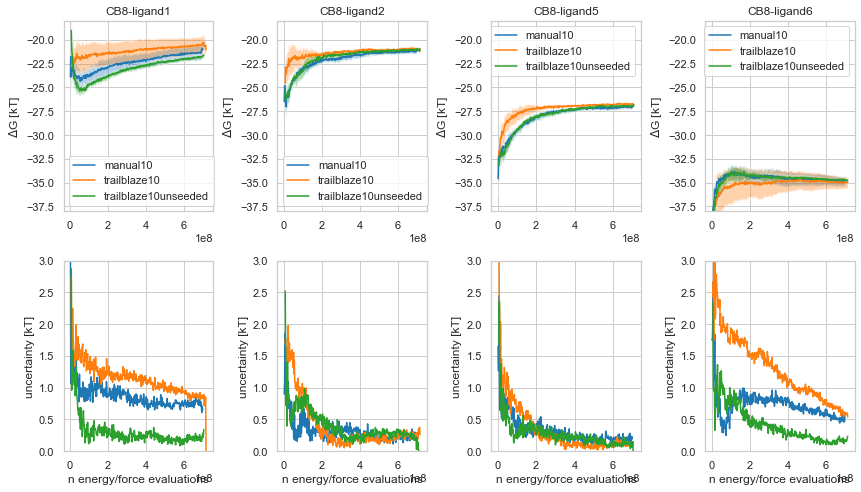

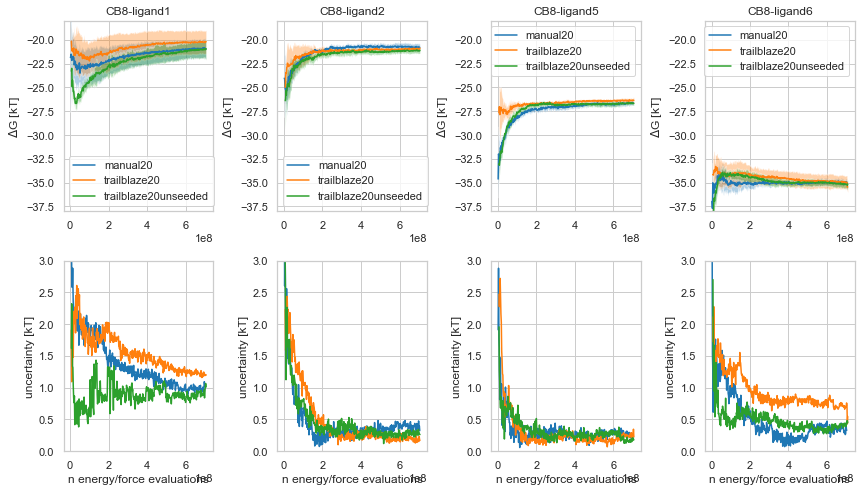

In [5]:
plot_free_trajectory_comparison(
    all_fe_trajectories=all_fe_trajectories,
    system_filter=cb8_system_filter,
    protocol_filter=lambda prot_name: '10' in prot_name,
    ylim=cb8_ylim, uncertainty_ylim=cb8_uncertainty_ylim,
    plot_mean=True, plot_uncertainty=True, plot_uncertainty_separately=True,
    output_file_name='CB8-10-f-traj.pdf'
)
plot_free_trajectory_comparison(
    all_fe_trajectories=all_fe_trajectories,
    system_filter=cb8_system_filter,
    protocol_filter=lambda prot_name: '20' in prot_name,
    ylim=cb8_ylim, uncertainty_ylim=cb8_uncertainty_ylim,
    plot_mean=True, plot_uncertainty=True, plot_uncertainty_separately=True,
    output_file_name='CB8-20-f-traj.pdf'
)

Now show the same for T4. For these I didn't run `unseeded trailblaze` protocols, but it looks like, with the exception of ligand6, even the seeded trailblaze protocol has very similar variance to the manual one.

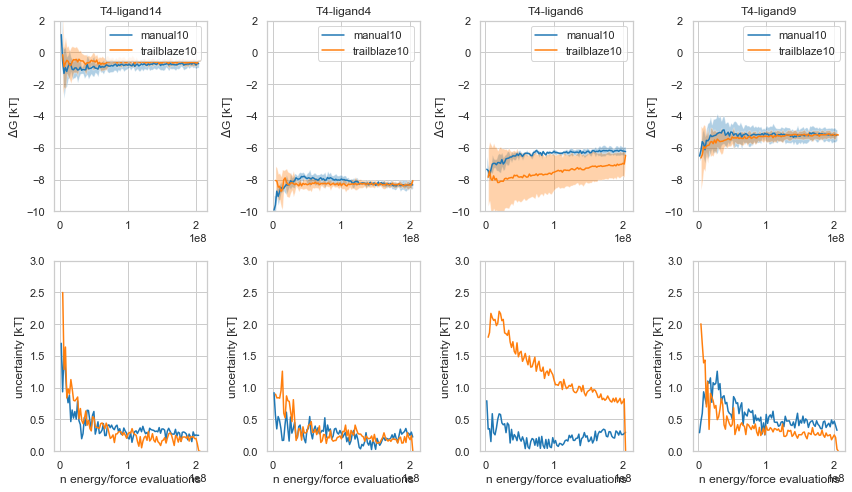

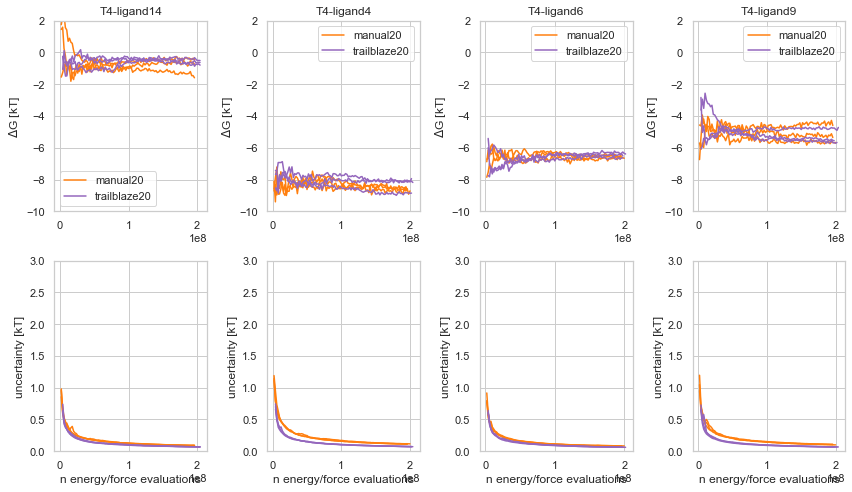

In [6]:
plot_free_trajectory_comparison(
    all_fe_trajectories=all_fe_trajectories,
    system_filter=t4_system_filter,
    protocol_filter=lambda prot_name: '10' in prot_name,
    ylim=t4_ylim, uncertainty_ylim=t4_uncertainty_ylim,
    plot_mean=True, plot_uncertainty=True, plot_uncertainty_separately=True,
)
plot_free_trajectory_comparison(
    all_fe_trajectories=all_fe_trajectories,
    system_filter=t4_system_filter,
    protocol_filter=lambda prot_name: '20' in prot_name,
    ylim=t4_ylim, uncertainty_ylim=t4_uncertainty_ylim,
    plot_mean=False, plot_uncertainty=False, plot_uncertainty_separately=True,
)

### The optimal thermodynamic spacing depends on the variance/bias trade-off of the particular system

When we compare unseeded runs with different spacing between thermodynamic states, the behavior seem to match what I'd expect. Reducing the number of states decreases the variance but increases the finite-sampling bias (as a function of the total computational cost).

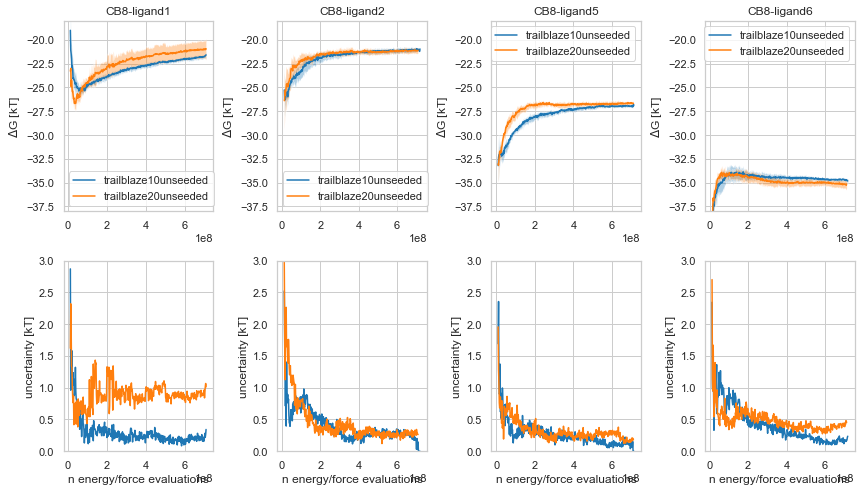

In [7]:
plot_free_trajectory_comparison(
    all_fe_trajectories=all_fe_trajectories,
    system_filter=cb8_system_filter,
    protocol_filter=lambda prot_name: 'unseeded' in prot_name,
    ylim=cb8_ylim, uncertainty_ylim=cb8_uncertainty_ylim,
    plot_mean=True, plot_uncertainty=True, plot_uncertainty_separately=True,
    output_file_name='CB8-unseeded-f-traj.pdf'
)

### For the "seeded" runs, the variance seems to be instead dominated by the set of initial conformations generated by trailblaze

When we use the samples generated by trailblazing to seed the replicas instead, the variance doesn't match the expectation. I believe the main responsible is again the seeding of the replicates, but this is a sign that the number of replicates is too small for a robust estimate. We may need to add a few more replicate calculations for a subset of these.

I also tried to compare `05` to `05short`. The second one, collects in total the same number of samples of `10` and `20` during trailblazing, which means it explores similar timescales. The idea was to show that `05` had higher variances becaused it sampled for longer at the beginning, but it doesn't seem this is generally true with this statistical power.

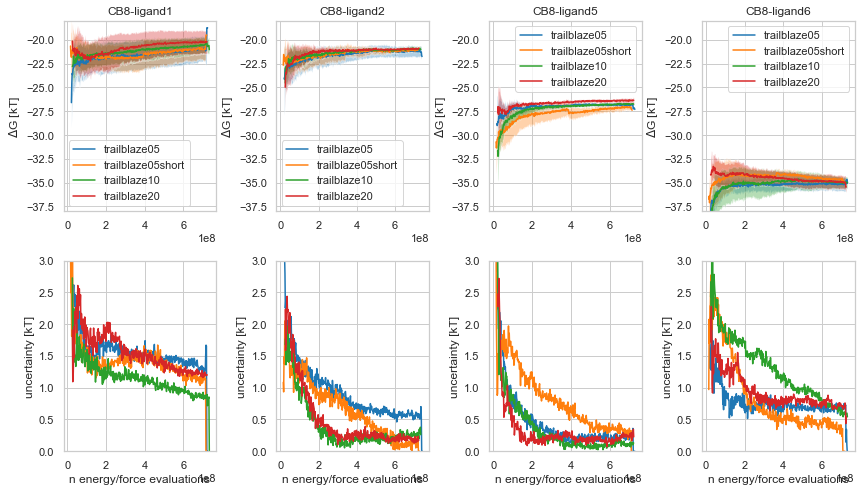

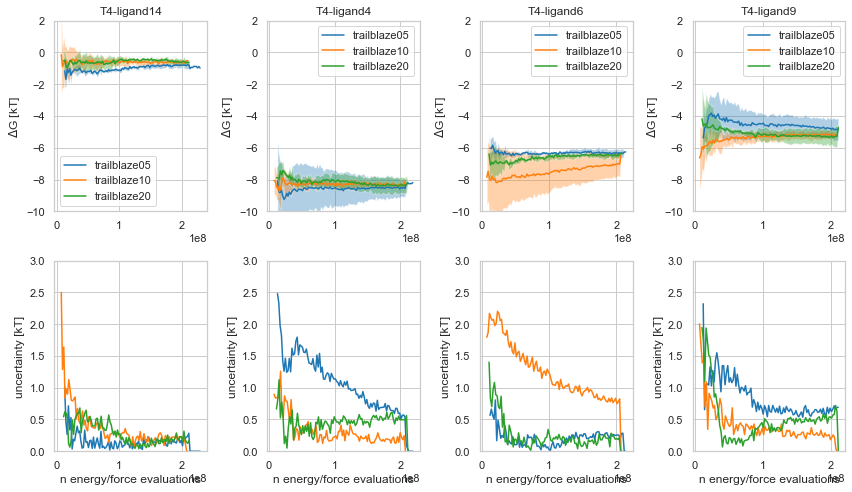

In [51]:
plot_free_trajectory_comparison(
    all_fe_trajectories=all_fe_trajectories,
    system_filter=cb8_system_filter,
    protocol_filter=lambda prot_name: 'trailblaze' in prot_name and 'unseeded' not in prot_name,# and prot_name != 'trailblaze05',
    ylim=cb8_ylim, uncertainty_ylim=cb8_uncertainty_ylim,
    plot_mean=True, plot_uncertainty=True, plot_uncertainty_separately=True,
)
plot_free_trajectory_comparison(
    all_fe_trajectories=all_fe_trajectories,
    system_filter=t4_system_filter,
    protocol_filter=lambda prot_name: 'trailblaze' in prot_name,
    ylim=t4_ylim, uncertainty_ylim=t4_uncertainty_ylim,
    plot_mean=True, plot_uncertainty=True, plot_uncertainty_separately=True,
)

## Thermodynamic length analysis

The goal here is to verify the following:

1. The standard deviation of the instantaneous work provides a good and simple estimator of the thermodynamic length based.
2. Thermodynamic trailblazing ends up separating the states equally in thermodynamic length even if the initial simulation is very short.
3. Thermodynamic trailblazing, contrarily to equal lambda-spacing protocols results in roughly constant acceptance rates between states.
4. The theoretical boundaries on acceptance rates predicted by Shenfeld and Xu are empirically satisfied even if we're not in the limit of an infinite number of intermediate states.

In [3]:
def read_all_thermo_length_data(filters=None):
    """Reads the thermo_length data generated by analyze_hrex_calculations.py.
    
    Parameters
    ----------
    filters : Set[str]
        Allows load only a subset of experiments whose name includes
        any of the substrings in filters.

    Returns
    -------
    thermo_length_data : Dict[str, Dict]
        Dict[experiment_name] is the deserialization of the JSON
        file stored in THERMO_LENGTH_DIR_PATH/ for the experiment.
    """
    thermo_length_data = collections.OrderedDict()
    for experiment_data_file_path in sorted(glob.glob(os.path.join(THERMO_LENGTH_DIR_PATH, '*.json'))):
        experiment_name = os.path.splitext(os.path.basename(experiment_data_file_path))[0]

        # Filter data.
        if filters is not None:
            for substring in filters:
                if substring in experiment_name:
                    # Match found.
                    break
            else:
                # Skip this experiment.
                continue
        
        # Load JSON data.
        with open(experiment_data_file_path, 'r') as f:
            thermo_length_data[experiment_name] = json.load(f)
    
    return thermo_length_data

### The standard deviation of the instantaneous work is a good estimator of the thermodynamic length.

In [4]:
def plot_thermo_length_estimators(estimates_to_plot=None, plot_derivative=False, plot_states_delta_L=False):
    sns.set_context('notebook')
    sns.set_style('whitegrid')

    if plot_derivative is True and plot_states_delta_L is True:
        raise ValueError('Only one between plot_derivative and plot_states_delta_L can be True.')

    # Handle mutable default argument.
    if estimates_to_plot is None:
        estimates_to_plot = ['L_def', 'L_JS', 'L_std_F', 'L_std_R', 'L_std_avg']

    # Load data.
    thermo_length_data = read_all_thermo_length_data()
    n_experiments = len(thermo_length_data)

    # Check if we need to plot the average std estimator too.
    plot_L_std_avg = 'L_std_avg' in estimates_to_plot

    # Plot all the systems.
    n_cols = 2
    n_rows = int(np.ceil(n_experiments / n_cols))
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6*n_cols, 6*n_rows))

    for exp_idx, (experiment_name, experiment_data) in enumerate(thermo_length_data.items()):
        phase_data = experiment_data['complex']
        n_states = len(phase_data['L_def'])

        # Find the Axes object to plot on.
        row_idx = int(exp_idx / n_cols)
        col_idx = exp_idx % n_cols
        ax = axes[row_idx, col_idx]

        # Compute the average std estimate if needed.
        if plot_L_std_avg:
            phase_data['L_std_avg'] = (np.array(phase_data['L_std_F']) + np.array(phase_data['L_std_R'])) / 2

        # Plot all estimates.
        for estimate_name in estimates_to_plot:
            ax.plot(phase_data[estimate_name], label=estimate_name)
        
        # Plot the derivative of the thermo length in a twin axis.
        if plot_states_delta_L:
            ax2 = ax.twinx()
            # Compute the separation in thermodynamic length between each pair of states.
            L_def = phase_data['L_def']  # Shortcut.
            delta_L = [L_def[i+1] - L_def[i] for i in range(n_states-1)]
            ax2.plot(np.array(list(range(n_states-1)))+0.5, delta_L,
                     ls='--', color='black', label='L[i+1] - L[i]')
            ax2.set_ylabel('L[i+1] - L[i]')
            ax2.set_ylim((0.0, 4.0))
        elif plot_derivative:
            ax2 = ax.twinx()
            ax2.plot(phase_data['dL_def'], ls='--', color='black', label='derivative')
            ax2.set_ylabel('Derivative thermo length')
        
        # Set axes and title.
        info = experiment_name_to_info(experiment_name)
        system_name, _, _, _, protocol_type, thermo_length_threshold, _ = info
        ax.set_title(f'{system_name} - {protocol_type} (s = {thermo_length_threshold} kT)')

        ax.set_ylabel('Thermodynamic length [kT]')
        ax.set_xlabel('State index')
        ax.legend()

    plt.tight_layout()
    plt.show()
    #plt.savefig('thermo_length.pdf')

The estimate built from the average of the forward and reverse standard deviation of the instantaneous work is systematically the closest to the finite difference estimate.

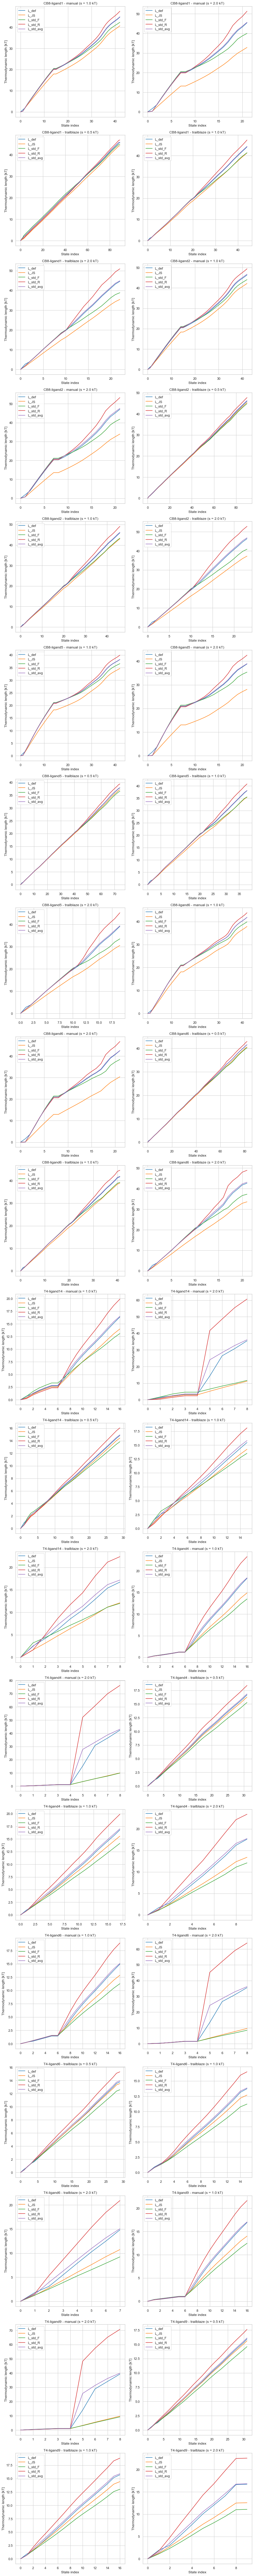

In [6]:
plot_thermo_length_estimators(plot_derivative=False)

### Thermodynamic trailblazing allows robust control of the neighbor acceptance rates

First, let's check how the lower and upper bounds of the neighbor acceptance rate vary with the thermodynamic distance between the two states.

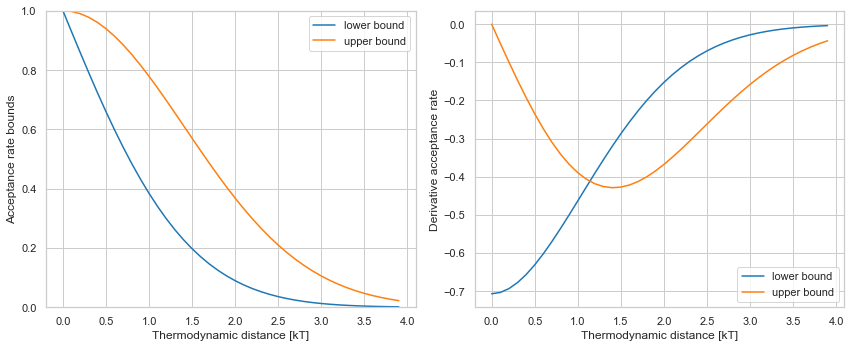

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
x = np.arange(0.0, 4.0, 0.1)

ax = axes[0]
ax.plot(x, lower_bound_neighbor_acceptance_rates(x), label='lower bound')
ax.plot(x, upper_bound_neighbor_acceptance_rates(x), label='upper bound')
ax.set_ylabel('Acceptance rate bounds')
ax.set_ylim((0, 1))

ax = axes[1]
ax.plot(x, derivative_lower_bound_neighbor_acceptance_rates(x), label='lower bound')
ax.plot(x, derivative_upper_bound_neighbor_acceptance_rates(x), label='upper bound')
ax.set_ylabel('Derivative acceptance rate')

for ax in axes:
    ax.set_xlabel('Thermodynamic distance [kT]')
    ax.legend()

plt.tight_layout()
plt.show()

In [28]:
def plot_acceptance_rates():
    """Plot the acceptance rates of all the experiments for trailblaze and manual protocols."""
    # TODO: Josh suggests using fill_between(alpha=0.1) for the theoretical bounds.
    # TODO: Josh suggests adding a third column with the various alchemical paths.
    # TODO: John suggests computing mixing stats: round-trip, state index autocorrelation, second-eigenvalue mixing time.
    sns.set_context('notebook')
    sns.set_style('whitegrid')

    # Read the data.
    thermo_length_data = read_all_thermo_length_data()

    # Collect all the analyzed experiments and systems.
    system_names = set(experiment_name_to_info(name)[0] for name in thermo_length_data)
    protocol_types = set(experiment_name_to_info(name)[4] for name in thermo_length_data)

    # One row for each receptor-ligand system, one col for trailblaze and manual protocols.
    n_rows = len(system_names)
    n_cols = len(protocol_types)
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(8*n_cols, 6*n_rows))
    system_name_to_row_idx = {name: i for i, name in enumerate(sorted(system_names))}
    protocol_type_to_col_idx = {name: i for i, name in enumerate(sorted(protocol_types))}

    # We bars and bounds using pair colors.
    palette = sns.color_palette('Paired')
    thermo_length_to_color = {0.5: 0, 1.0: 1, 2.0: 2}

    # Keep track of the maximum number of states in each axes,
    # which we'll use later to make the ticks less crowded.
    max_n_states = np.zeros(shape=axes.shape, dtype=np.int)

    # Plot all the data.
    for experiment_name, experiment_data in thermo_length_data.items():
        # Get info for the experiment.
        info = experiment_name_to_info(experiment_name)
        system_name, _, _, _, protocol_type, thermo_length_threshold, _ = info

        # Find axes object to plot on.
        row_idx = system_name_to_row_idx[system_name]
        col_idx = protocol_type_to_col_idx[protocol_type]
        ax = axes[row_idx, col_idx]

        # Determine colors.
        color_idx = thermo_length_to_color[thermo_length_threshold]
        bar_color = palette[2*color_idx]
        bound_color = palette[2*color_idx + 1]

        # Bar plot for acceptance rates.
        neighbor_acceptance_rates = experiment_data['complex']['acceptance']
        n_states = len(neighbor_acceptance_rates) + 1
        all_states = list(range(n_states-1))
        sns.barplot(all_states, neighbor_acceptance_rates, color=bar_color, ax=ax,
                    label=f'thermo distance = {thermo_length_threshold}kT',
                    zorder=thermo_length_threshold)

        # Update max number of states.
        max_n_states[row_idx, col_idx] = max(max_n_states[row_idx, col_idx], n_states)

        # Plot lower and upper bounds if this a protocol found through trailblazing.
        if protocol_type == 'trailblaze':
            l_bound = lower_bound_neighbor_acceptance_rates(thermo_length_threshold)
            u_bound = upper_bound_neighbor_acceptance_rates(thermo_length_threshold)
            ax.plot(all_states, [l_bound for _ in all_states], color=bound_color,
                    zorder=thermo_length_threshold*4)
            ax.plot(all_states, [u_bound for _ in all_states], color=bound_color,
                    zorder=thermo_length_threshold*4)

        # Configure axes.
        ax.set_title(f'{protocol_type} protocol - {system_name}')
        ax.set_ylabel('neighbor acceptance rate')
        ax.set_xlabel('state index')
        ax.set_ylim((0, 1))

        ax.legend()

    # Fix x-axis ticks.
    for n_states, ax in zip(max_n_states.flatten(), axes.flatten()):
        # Make the ticks less crowded.
        ticks = list(range(0, n_states, 3))
        tick_labels = [str(i) for i in ticks]

        # We set the ticks **between** states since bars represent acceptance rates between pairs.
        ticks = np.array(ticks) - 0.5
        ax.set_xticklabels(tick_labels)
        ax.set_xticks(ticks)

    plt.tight_layout()
    plt.show()

This is a plot of the acceptance rates between neighbor states obtained by HREX for the different protocols. On the left, the simulation using the manual, equally-spaced lambda windows, and on the right the trailblaze protocol. The manual protocols used for a receptor have a number of intermediate states equal to the average number of states found by the trailblaze algorithm. The horizontal lines represent the theoretical bounds (from Shenfeld 2009) on the neighbor acceptance rate for the thermodynamic length threshold that was used during thermodynamic trailblazing.

The acceptance rates are always within theoretical predictions even if we don't have a continuous range of states. Also the manual protocol, with equally spaced lambda windows vary a lot across states and between systems.

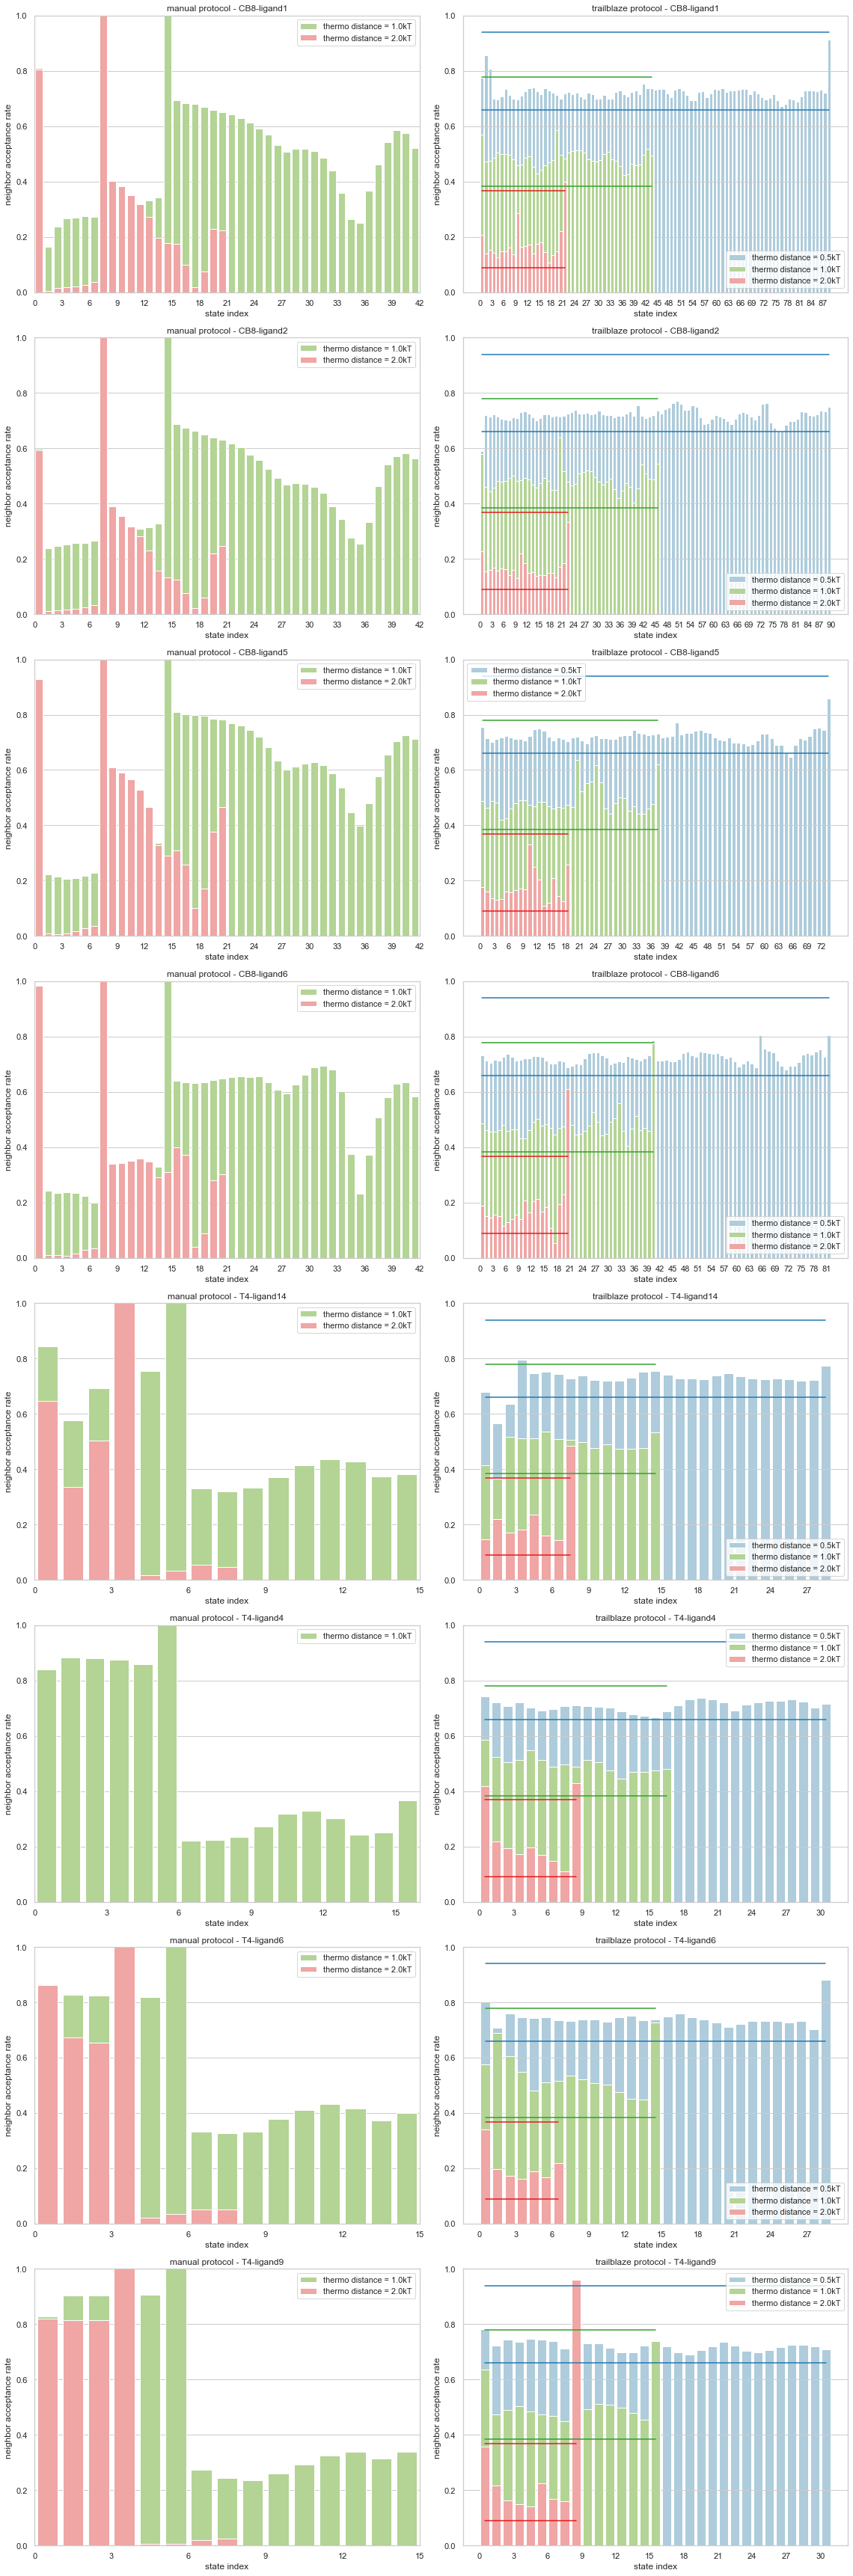

In [29]:
plot_acceptance_rates()